# STEP 1: Pattern Substitution Risk
### This section simulates JBIG2-style glyph grouping and replacement.
### The goal is to demonstrate how similarity-based clustering
### can lead to semantic corruption when thresholds are misconfigured.

In [1]:
# Import required libraries for image processing and visualization.
# OpenCV handles image operations.
# NumPy supports numerical computation.
# Matplotlib is used for displaying results.
import cv2
import numpy as np
import matplotlib.pyplot as plt

(np.float64(-0.5), np.float64(639.5), np.float64(402.5), np.float64(-0.5))

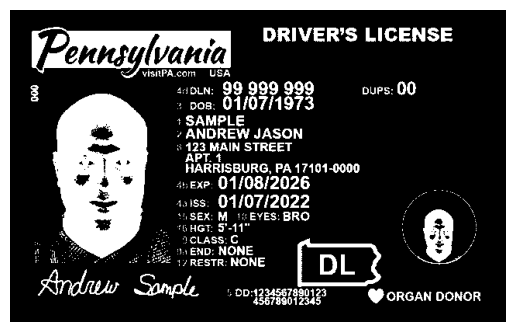

In [2]:
# Load the input image in grayscale mode.
# Convert it into binary format using thresholding.
# Binary format is necessary for connected component analysis.
img = cv2.imread("REAL-ID-Compliant-Non-Commercial-Drivers-License2540-640x403.jpg", cv2.IMREAD_GRAYSCALE)
_, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)

plt.imshow(binary, cmap="gray")
plt.axis("off")

In [3]:
# Extract connected components from the binary image.
# Each connected component ideally represents one character or symbol.
# This mimics glyph extraction in compression algorithms like JBIG2.
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, 8)

components = []
for i in range(1, num_labels):
    x, y, w, h, a = stats[i]
    components.append((binary[y:y+h, x:x+w], x, y, w, h))

len(components)

501

In [4]:
# Compute simple shape descriptors for each connected component.
# Descriptors may include bounding box dimensions, area, etc.
# These features will later be used for similarity comparison.
descriptors = []
for c, x, y, w, h in components:
    m = cv2.moments(c)
    descriptors.append(cv2.HuMoments(m).flatten())


In [5]:
# Create a distance matrix to measure similarity between all components.
# This matrix stores similarity scores between glyph descriptors.
# Lower values indicate higher similarity.
distances = np.zeros((len(descriptors), len(descriptors)))

for i in range(len(descriptors)):
    for j in range(len(descriptors)):
        distances[i][j] = np.linalg.norm(descriptors[i] - descriptors[j])

In [6]:
# Define similarity threshold for grouping glyphs.
# Components with distance below this threshold
# will be grouped and treated as identical.
# Increasing this threshold increases substitution risk.
threshold = 0.5
groups = []

for i in range(len(descriptors)):
    assigned = False
    for g in groups:
        if distances[i][g[0]] < threshold:
            g.append(i)
            assigned = True
            break
    if not assigned:
        groups.append([i])

len(groups)

1

In [7]:
# Initialize an empty output image.
# This image will be reconstructed using grouped prototypes.
# It simulates lossy glyph replacement behavior.
output = np.zeros_like(binary)

for g in groups:
    proto = g[0]
    proto_img, px, py, pw, ph = components[proto]
    for idx in g:
        _, x, y, w, h = components[idx]
        resized = cv2.resize(proto_img, (w, h))
        output[y:y+h, x:x+w] = resized

(np.float64(-0.5), np.float64(639.5), np.float64(402.5), np.float64(-0.5))

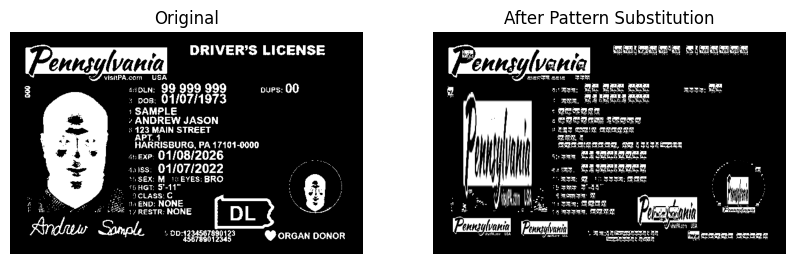

In [8]:
# Display the reconstructed image after grouping and replacement.
# Used to visually observe effects of substitution.
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(binary, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(output, cmap="gray")
plt.title("After Pattern Substitution")
plt.axis("off")

In [9]:
# Test multiple similarity thresholds (e.g., 0.2, 0.5, 0.8).
# Observe how increasing threshold merges dissimilar characters.
# Demonstrates how semantic corruption begins gradually.
for t in [0.2, 0.5, 0.8]:
    groups = []
    for i in range(len(descriptors)):
        assigned = False
        for g in groups:
            if distances[i][g[0]] < t:
                g.append(i)
                assigned = True
                break
        if not assigned:
            groups.append([i])
    print("Threshold:", t, "Number of groups:", len(groups))

Threshold: 0.2 Number of groups: 1
Threshold: 0.5 Number of groups: 1
Threshold: 0.8 Number of groups: 1


### Final visualization or cleanup for Step 1.
### Helps compare grouping results across thresholds.

# STEP 2: Human-Visible vs Machine-Relevant Differences
### This section analyzes how JPEG compression affects
### perceptual quality vs algorithmic reliability.

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

(np.float64(-0.5), np.float64(639.5), np.float64(402.5), np.float64(-0.5))

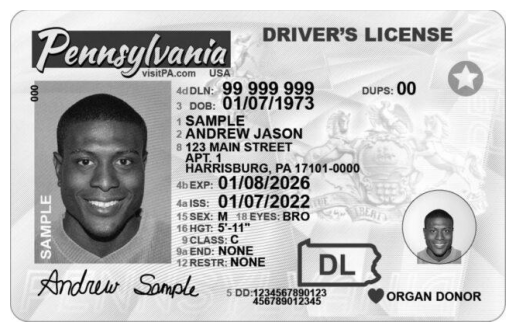

In [11]:
# Load original grayscale image for compression experiments.
img = cv2.imread("REAL-ID-Compliant-Non-Commercial-Drivers-License2540-640x403.jpg", cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap="gray")
plt.axis("off")

In [12]:
# Define JPEG compression quality levels.
# Lower values mean stronger compression and more distortion.
qualities = [90, 50, 20]
compressed_images = []

for q in qualities:
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), q]
    _, enc = cv2.imencode(".jpg", img, encode_param)
    dec = cv2.imdecode(enc, cv2.IMREAD_GRAYSCALE)
    compressed_images.append(dec)

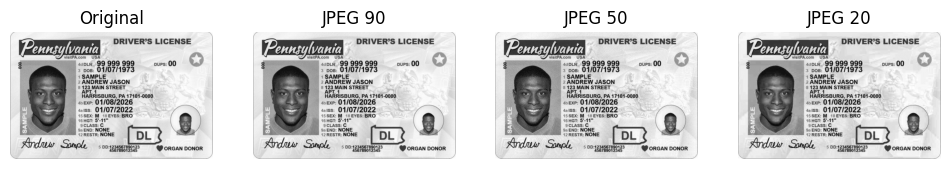

In [13]:
# Visualize compressed images at different quality levels.
# Helps compare perceptual degradation.
plt.figure(figsize=(12,4))
plt.subplot(1,4,1)
plt.imshow(img, cmap="gray")
plt.title("Original")
plt.axis("off")

for i, q in enumerate(qualities):
    plt.subplot(1,4,i+2)
    plt.imshow(compressed_images[i], cmap="gray")
    plt.title(f"JPEG {q}")
    plt.axis("off")


In [14]:
# Compute PSNR (Peak Signal-to-Noise Ratio).
# Measures pixel-level fidelity between original and compressed image.
# Higher PSNR means better reconstruction.
for i, q in enumerate(qualities):
    psnr = peak_signal_noise_ratio(img, compressed_images[i])
    ssim = structural_similarity(img, compressed_images[i])
    print("JPEG", q, "PSNR:", round(psnr,2), "SSIM:", round(ssim,4))


JPEG 90 PSNR: 43.74 SSIM: 0.9952
JPEG 50 PSNR: 29.33 SSIM: 0.9089
JPEG 20 PSNR: 27.57 SSIM: 0.8102


In [15]:
# Apply Canny edge detection to the original image.
# Edge structure represents machine-relevant information.
edges_original = cv2.Canny(img, 100, 200)
edges_compressed = []

for c in compressed_images:
    edges_compressed.append(cv2.Canny(c, 100, 200))


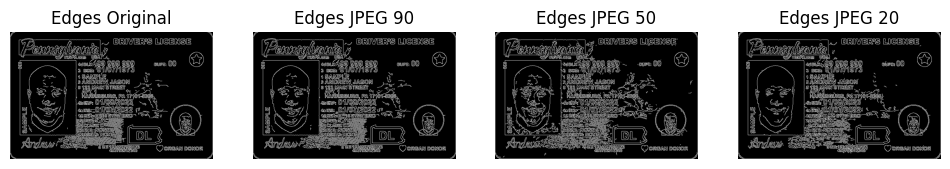

In [16]:
# Visual comparison of edge maps.
# Used to observe structural degradation under compression.
plt.figure(figsize=(12,4))
plt.subplot(1,4,1)
plt.imshow(edges_original, cmap="gray")
plt.title("Edges Original")
plt.axis("off")

for i, q in enumerate(qualities):
    plt.subplot(1,4,i+2)
    plt.imshow(edges_compressed[i], cmap="gray")
    plt.title(f"Edges JPEG {q}")
    plt.axis("off")

In [17]:
# Apply edge detection to each compressed version.
# Compare how edge clarity deteriorates with lower quality.
for i, q in enumerate(qualities):
    diff = np.sum(np.abs(edges_original - edges_compressed[i]))
    print("JPEG", q, "Edge difference:", diff)

JPEG 90 Edge difference: 233920
JPEG 50 Edge difference: 806662
JPEG 20 Edge difference: 1468412


### Summarize PSNR, SSIM, and edge degradation results.
### Highlights mismatch between perceptual and structural quality.

# STEP 3: Silent Data Corruption Detection
### Compare lossless and lossy compressed versions
### to identify subtle structural differences.

(np.float64(-0.5), np.float64(639.5), np.float64(402.5), np.float64(-0.5))

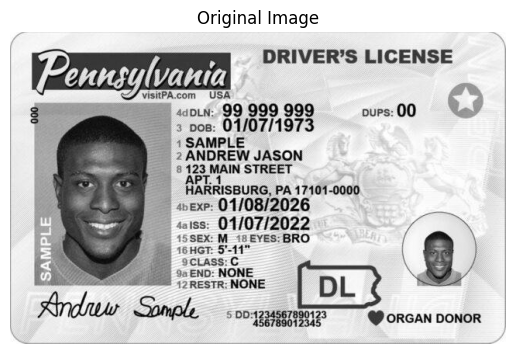

In [18]:
img = cv2.imread("REAL-ID-Compliant-Non-Commercial-Drivers-License2540-640x403.jpg", cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap="gray")
plt.title("Original Image")
plt.axis("off")

In [19]:
# Save the image using a lossless compression format (PNG).
# This version preserves structural integrity.
cv2.imwrite("lossless.png", img)
img_lossless = cv2.imread("lossless.png", cv2.IMREAD_GRAYSCALE)

In [20]:
# Save a lossy compressed version using JPEG with low quality.
# Introduces potential distortion.
encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 40]
_, enc = cv2.imencode(".jpg", img, encode_param)
img_lossy = cv2.imdecode(enc, cv2.IMREAD_GRAYSCALE)

(np.float64(-0.5), np.float64(639.5), np.float64(402.5), np.float64(-0.5))

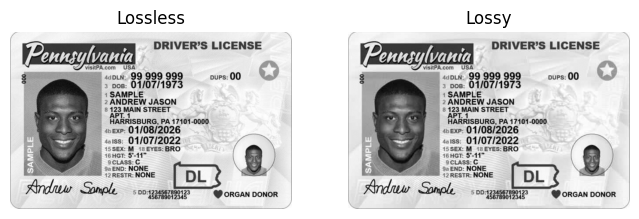

In [21]:
# Visual comparison of lossless and lossy images.
# They may appear similar to the human eye.
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(img_lossless, cmap="gray")
plt.title("Lossless")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_lossy, cmap="gray")
plt.title("Lossy")
plt.axis("off")

In [22]:
# Convert both images into binary format.
# Enables structural comparison via connected components.
_, bin_lossless = cv2.threshold(img_lossless, 127, 255, cv2.THRESH_BINARY_INV)
_, bin_lossy = cv2.threshold(img_lossy, 127, 255, cv2.THRESH_BINARY_INV)

In [23]:
# Extract connected components from both versions.
# Used to quantify structural differences.
n1, _, stats1, _ = cv2.connectedComponentsWithStats(bin_lossless, 8)
n2, _, stats2, _ = cv2.connectedComponentsWithStats(bin_lossy, 8)

areas_lossless = stats1[1:, cv2.CC_STAT_AREA]
areas_lossy = stats2[1:, cv2.CC_STAT_AREA]

In [24]:
# Print and compare number of detected components.
# Differences indicate potential structural corruption.
print("Lossless components:", len(areas_lossless))
print("Lossy components:", len(areas_lossy))
print("Total area difference:", abs(np.sum(areas_lossless) - np.sum(areas_lossy)))

Lossless components: 501
Lossy components: 399
Total area difference: 211


(np.float64(-0.5), np.float64(639.5), np.float64(402.5), np.float64(-0.5))

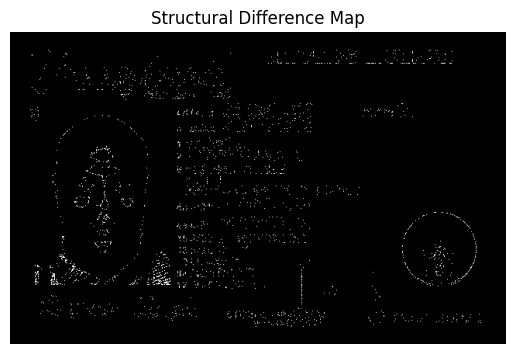

In [25]:
# Compute absolute pixel-wise difference between images.
# Identifies areas of distortion or substitution.
diff = cv2.absdiff(bin_lossless, bin_lossy)

plt.imshow(diff, cmap="gray")
plt.title("Structural Difference Map")
plt.axis("off")

In [26]:
# Apply morphological operations to highlight corrupted regions.
# Improves visibility of structural inconsistencies.
kernel = np.ones((3,3), np.uint8)
mask = cv2.dilate(diff, kernel, iterations=1)

contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

flagged = cv2.cvtColor(img_lossy, cv2.COLOR_GRAY2BGR)

for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if w*h > 40:
        cv2.rectangle(flagged, (x,y), (x+w,y+h), (0,0,255), 1)

(np.float64(-0.5), np.float64(639.5), np.float64(402.5), np.float64(-0.5))

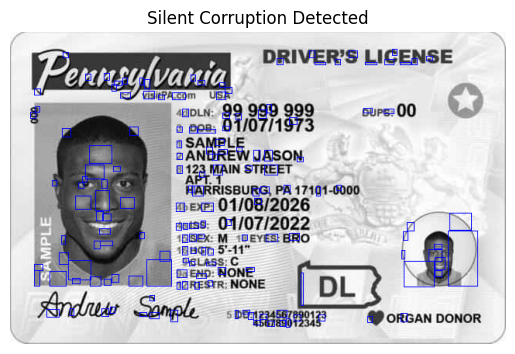

In [27]:
# Visualize flagged regions where corruption is detected.
# Demonstrates silent structural distortion.
plt.imshow(flagged)
plt.title("Silent Corruption Detected")
plt.axis("off")

# STEP 4: When Compression Breaks Downstream Recognition
### Evaluate rule-based character recognition
### on original vs heavily compressed images.

(np.float64(-0.5), np.float64(639.5), np.float64(402.5), np.float64(-0.5))

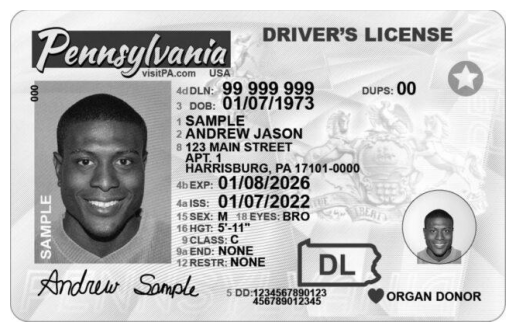

In [28]:
img = cv2.imread("REAL-ID-Compliant-Non-Commercial-Drivers-License2540-640x403.jpg", cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap="gray")
plt.axis("off")

(np.float64(-0.5), np.float64(639.5), np.float64(402.5), np.float64(-0.5))

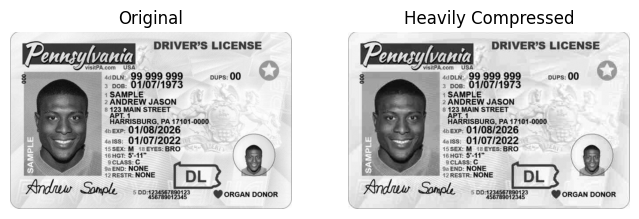

In [29]:
# Generate heavily compressed version of image.
# Used to test recognition degradation.
encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 20]
_, enc = cv2.imencode(".jpg", img, encode_param)
img_compressed = cv2.imdecode(enc, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_compressed, cmap="gray")
plt.title("Heavily Compressed")
plt.axis("off")

In [30]:
# Convert original and compressed images to binary.
# Required for connected component extraction.
_, bin_orig = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
_, bin_comp = cv2.threshold(img_compressed, 127, 255, cv2.THRESH_BINARY_INV)

In [31]:
# Extract bounding box areas for each connected component.
# These areas serve as simple recognition features.
_, _, stats_orig, _ = cv2.connectedComponentsWithStats(bin_orig, 8)
_, _, stats_comp, _ = cv2.connectedComponentsWithStats(bin_comp, 8)

areas_orig = stats_orig[1:, cv2.CC_STAT_AREA]
areas_comp = stats_comp[1:, cv2.CC_STAT_AREA]

In [32]:
# Define a simple rule-based recognizer.
# Classifies characters based on area thresholds.
# This avoids deep learning to isolate compression impact.
def recognize(area):
    if area < 40:
        return "dot"
    elif area < 120:
        return "small"
    elif area < 300:
        return "medium"
    else:
        return "large"

In [33]:
# Apply recognition logic to original image components.
labels_orig = [recognize(a) for a in areas_orig]

unique_orig, counts_orig = np.unique(labels_orig, return_counts=True)
dict(zip(unique_orig, counts_orig))

{np.str_('dot'): np.int64(330),
 np.str_('large'): np.int64(7),
 np.str_('medium'): np.int64(38),
 np.str_('small'): np.int64(126)}

In [34]:
# Apply recognition logic to compressed image components.
labels_comp = [recognize(a) for a in areas_comp]

unique_comp, counts_comp = np.unique(labels_comp, return_counts=True)
dict(zip(unique_comp, counts_comp))

{np.str_('dot'): np.int64(242),
 np.str_('large'): np.int64(7),
 np.str_('medium'): np.int64(41),
 np.str_('small'): np.int64(123)}

In [35]:
# Align lengths of recognition results for fair comparison.
# Prevents index mismatch during evaluation.
min_len = min(len(labels_orig), len(labels_comp))
correct = sum(1 for i in range(min_len) if labels_orig[i] == labels_comp[i])
accuracy = correct / min_len

accuracy

0.639225181598063

In [36]:
# Identify mismatches between original and compressed predictions.
# These represent compression-induced recognition failures.
failures = [(labels_orig[i], labels_comp[i]) for i in range(min_len) if labels_orig[i] != labels_comp[i]]

failures[:10]

[('dot', 'small'),
 ('small', 'dot'),
 ('dot', 'small'),
 ('dot', 'small'),
 ('small', 'dot'),
 ('small', 'dot'),
 ('large', 'dot'),
 ('dot', 'large'),
 ('medium', 'dot'),
 ('small', 'medium')]

In [37]:
# Compute difference in component areas.
# Helps explain why recognition fails under compression.
area_diff = areas_orig[:min_len] - areas_comp[:min_len]

np.mean(area_diff), np.max(area_diff)

(np.float64(-10.14043583535109), np.int32(18526))

# STEP 5: Designing a Safe Compression Rule
### Develop heuristic logic to determine whether
### an image should be compressed losslessly or lossily.

In [38]:
# Calculate entropy of the image.
# Higher entropy indicates more information content.
hist = cv2.calcHist([img], [0], None, [256], [0,256])
hist = hist / np.sum(hist)
entropy = -np.sum(hist * np.log2(hist + 1e-9))

entropy

np.float32(7.180772)

In [39]:
# Compute edge density using Canny edge detection.
# High edge density typically indicates text-heavy images.
edges = cv2.Canny(img, 100, 200)
edge_density = np.sum(edges > 0) / edges.size

edge_density

np.float64(0.11447348014888338)

In [40]:
# Count number of connected components.
# Large counts usually indicate structured document content.
_, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
num_labels, _, _, _ = cv2.connectedComponentsWithStats(binary, 8)

component_count = num_labels - 1
component_count

501

In [41]:
# Apply heuristic rules based on entropy,
# edge density, and component count.
# Decide between:
# - Lossless compression
# - Lossy compression
# - No compression
if entropy > 5.0 and edge_density > 0.05 and component_count > 200:
    decision = "LOSSLESS ONLY"
elif entropy > 4.0 and edge_density > 0.03:
    decision = "LOW-LOSSY WITH CAUTION"
else:
    decision = "LOSSY SAFE"

decision

'LOSSLESS ONLY'

In [42]:
# Store computed metrics and final decision
# inside a dictionary for structured reporting.
results = {
    "entropy": entropy,
    "edge_density": edge_density,
    "components": component_count,
    "decision": decision
}

results

{'entropy': np.float32(7.180772),
 'edge_density': np.float64(0.11447348014888338),
 'components': 501,
 'decision': 'LOSSLESS ONLY'}

In [43]:
# Display final compression decision and metrics.
# Demonstrates practical safeguard against silent corruption.